In [2]:
import pandas as pd
import numpy as np

# 불용어,표제어(토큰) 처리했음

# 실험용 아래 실험용임

In [11]:
import pandas as pd
import re
from konlpy.tag import Okt
from joblib import Parallel, delayed

# 파일 로드
file_path = '무슨데이터인지모르겠으나_csv/combined_data.csv'
data = pd.read_csv(file_path)

# 열 이름 확인 후 텍스트 데이터 열 지정
review_column = 'Review Text' if 'Review Text' in data.columns else None

# 확장된 한국어 불용어 리스트
stopwords = [
    # 조사
    '이', '가', '은', '는', '을', '를', '에', '에서', '으로', '로', '와', '과', '도', '만', '의', 
    '에게', '께', '께서', '보다', '한테', '이랑', '랑', '이라', '같이', '처럼',
    # 대명사
    '그', '저', '이것', '그것', '저것', '뭐', '어느', '어떤', '다른', '모든', '아무', '누구', '무엇',
    # 부사
    '매우', '너무', '좀', '조금', '정말', '아주', '다시', '더', '좀더', '게', '별로', '뭐',
    '항상', '자주', '엄청', '요즘', '살짝', '이제', '확실히',
    # 동사 및 기타
    '합니다', '합니다만', '했다', '되어', '되고', '되며', '되지', '되는', '되어야', '있다', '없다',
    '합니다만', '있습니다', '것이다', '같다', '이다', '하는', '하나', '하면', '하려고', '하려면', '하세요',
    '되다', '됩니까',
    # 일반 단어
    '등', '수', '것', '거', '때', '시', '해', '곳', '듯', '양', '중', '앞', '뒤', '위', '아래', 
    '사람', '사람들', '우리', '너희', '너', '나', '저', '제', '그들', '하다',
    # 추가된 단어
    '역시', '바로', '저는', '있지만', '하고','그래도','잘','자다'
]

if review_column:
    # 영어 텍스트 포함 행 제거 (추가된 부분)
    data = data[~data[review_column].str.contains(r'[a-zA-Z]', na=False)]

    
    # 결측값 제거 
data = data.dropna(subset=['Review Text'])


# 2. 특수문자 및 중복 문자 제거
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # 특수문자 제거
    text = re.sub(r'(.)\1{2,}', r'\1', text)  # 같은 글자 반복 제거 (예: ㅇㅇㅇㅇ → ㅇ)
    text = re.sub(r'\s+', ' ', text)  # 공백 여러 개를 하나로 줄임
    text = re.sub(r'\d+', '', text)  # 숫자 제거
    text = re.sub(r'[ㄱ-ㅎㅏ-ㅣ]+', '', text)  # 한글 자음, 모음 제거 (예: ㅋㅋ, ㅎㅎ, ㅏ)
    return text.strip()

data[review_column] = data[review_column].apply(clean_text)

# 3. 병렬 처리로 토큰화 및 품사 추출
def preprocess_text(text):
    # 워커 프로세스 내부에서 Okt 객체 초기화
    okt = Okt()
    tokens = okt.pos(text, norm=True, stem=True)
    return [word for word, pos in tokens if pos in ['Noun', 'Adjective', 'Verb']]

data['Tokens'] = Parallel(n_jobs=-1)(delayed(preprocess_text)(text) for text in data[review_column])

# 4. 불용어 제거
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stopwords and len(word) > 1]

# 병렬 처리로 불용어 제거
data['Tokens'] = Parallel(n_jobs=-1)(delayed(remove_stopwords)(tokens) for tokens in data['Tokens'])

# 결과를 CSV로 저장
data.to_csv('preprocessed_review_data.csv', index=False, encoding='utf-8-sig')
print("전처리가 완료되었습니다. 'preprocessed_review_data.csv' 파일로 저장되었습니다.")


    



전처리가 완료되었습니다. 'preprocessed_review_data.csv' 파일로 저장되었습니다.


In [12]:
data.isnull().sum()

Star Rating    0
Review Text    0
Tokens         0
dtype: int64

In [40]:
file_path = 'preprocessed_review_data.csv'
data2 = pd.read_csv(file_path)
data2

,Star Rating,Review Text,Tokens
0,5점,사용하기 편리하고 넘 촉촉해요 요즘 잘 쓰고 있어요,"['사용', '편리하다', '넘다', '촉촉하다', '요즘', '자다', '쓰다']"
1,5점,잘 사용하겠습니다,"['자다', '사용']"
2,5점,쫀쫀해요 화장이 잘 받아요,"['쫀쫀해', '화장', '자다', '받다']"
3,5점,종류가 많아 고르기 좋고 사용이 편리해요,"['종류', '많다', '고르다', '좋다', '사용', '편리하다']"
4,5점,알로에랑 두종류 구매했는데좋네요,"['알로', '종류', '구매', '좋다']"
...,...,...,...
26757,5점,추천받아서 써봤는데 자고 일어나면 은은하게 광이 생기는 느낌,"['추천', '받다', '써다', '자고', '일어나다', '은은하다', '생기다'..."
26758,4점,개별 파우치라 위생적 간편함,"['개별', '파우치', '위생', '간편하다']"
26759,4점,하고나면 촉촉하네요 개별파우치라 위생접,"['촉촉하다', '개별', '파우치', '위생']"
26760,4점,건조되는시간이 길긴한데 팩하고나면 촉촉하고 괜찮아요,"['건조', '시간', '길다', '촉촉하다', '괜찮다']"


In [24]:
pip install textblob



   ---------------------------------------- 0.0/626.3 kB ? eta -:--:--
   ---------------------------------------- 626.3/626.3 kB 7.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 11.4 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.7
    Uninstalling nltk-3.7:
      Successfully uninstalled nltk-3.7


In [29]:
from textblob import download_corpora

# TextBlob 코퍼스 다운로드
download_corpora()


TypeError: 'module' object is not callable

In [28]:
import textblob
textblob.download_corpora()

AttributeError: module 'textblob' has no attribute 'download_corpora'

In [30]:
import nltk

# 필요한 데이터 다운로드
nltk.download('punkt')       # 문장 토큰화를 위한 데이터
nltk.download('averaged_perceptron_tagger')  # 품사 태그를 위한 데이터


[nltk_data] Downloading package punkt to C:\Users\chco.DESKTOP-
[nltk_data]     DVEQHPF\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\chco.DESKTOP-
[nltk_data]     DVEQHPF\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [49]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# 데이터 로드
file_path = 'preprocessed_review_data.csv'
data = pd.read_csv(file_path)

# 텍스트 열과 별점 열 확인
tokens_column = 'Tokens'  # 토큰화된 데이터가 저장된 열
star_rating_column = 'Star Rating'

# 토큰 리스트를 문자열로 변환 (TF-IDF와 LDA는 문자열 입력을 요구함)
data['Tokens_Text'] = data[tokens_column].apply(lambda x: ' '.join(eval(x)) if isinstance(x, str) else '')

# 1️⃣ TF-IDF 분석 (중요 단어 찾기)
def tfidf_analysis(data, tokens_column, n_keywords=30):
    vectorizer = TfidfVectorizer(max_features=1000)
    tfidf_matrix = vectorizer.fit_transform(data[tokens_column].dropna())
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

    # 평균 TF-IDF 점수 계산
    tfidf_mean = tfidf_df.mean(axis=0).sort_values(ascending=False)
    top_keywords = tfidf_mean.head(n_keywords)
    return top_keywords

# 2️⃣ LDA 분석 (주제 찾기)
def lda_analysis(data, tokens_column, n_topics=8, n_keywords=10):
    vectorizer = TfidfVectorizer(max_features=1000)
    tfidf_matrix = vectorizer.fit_transform(data[tokens_column].dropna())
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(tfidf_matrix)

    keywords = vectorizer.get_feature_names_out()
    topic_keywords = {}
    for topic_idx, topic in enumerate(lda.components_):
        top_keywords = [keywords[i] for i in topic.argsort()[:-n_keywords - 1:-1]]
        topic_keywords[f"Topic {topic_idx + 1}"] = top_keywords
    return topic_keywords

# 3️⃣ 감성 분석 (긍정/부정)
def sentiment_analysis(data, star_rating_column):
    def get_sentiment_from_rating(rating):
        if rating == 5:
            return 'Positive'
        elif rating in [1, 2]:
            return 'Negative'
        else:
            return 'Neutral'

    data['Sentiment'] = data[star_rating_column].apply(get_sentiment_from_rating)
    sentiment_counts = data['Sentiment'].value_counts()
    return sentiment_counts

# 실행
print("1️⃣ TF-IDF 분석 중...")
tfidf_keywords = tfidf_analysis(data, 'Tokens_Text')
print("TF-IDF 결과:")
print(tfidf_keywords)

print("2️⃣ LDA 주제 분석 중...")
lda_topics = lda_analysis(data, 'Tokens_Text')
print("LDA 결과:")
for topic, keywords in lda_topics.items():
    print(f"{topic}: {', '.join(keywords)}")

print("3️⃣ 감성 분석 중...")
sentiment_result = sentiment_analysis(data, star_rating_column)
print("감성 분석 결과:")
print(sentiment_result)

print("분석 완료!")


1️⃣ TF-IDF 분석 중...
TF-IDF 결과:
좋다      0.111339
사용      0.059156
구매      0.043938
자다      0.036740
써다      0.035921
피부      0.034807
자극      0.034428
쓰다      0.030589
효과      0.027435
바르다     0.024429
촉촉하다    0.024014
재다      0.021016
리들샷     0.020586
제품      0.019554
사다      0.018558
배송      0.018371
해보다     0.018270
꾸준하다    0.016426
받다      0.016103
느낌      0.016034
좋아지다    0.015484
않다      0.015479
편하다     0.015332
다이소     0.015113
빠르다     0.014942
따갑다     0.014550
괜찮다     0.014476
들다      0.014149
구입      0.013182
계속      0.013168
dtype: float64
2️⃣ LDA 주제 분석 중...
LDA 결과:
Topic 1: 재다, 좋다, 써다, 구매, 처음, 후기, 추천, 따갑다, 사용, 생각
Topic 2: 배송, 빠르다, 좋다, 가성, 다이소, 제품, 최고, 상품, 구매, 살다
Topic 3: 좋다, 사용, 자다, 구매, 쓰다, 써다, 해보다, 꾸준하다, 사다, 만족하다
Topic 4: 받다, 감사하다, 구매, 좋다, 품절, 매장, 인기, 온라인, 해주다, 자다
Topic 5: 가격, 잘쓰다, 좋다, 저렴하다, 사용, 기대, 전이, 대비, 피부, 흡수
Topic 6: 써다, 유명하다, 좋다, 기대하다, 구매, 거리, 피부, 사용, 효과, 차다
Topic 7: 자극, 피부, 좋아지다, 바르다, 느낌, 않다, 좋다, 확실하다, 사용, 쓰다
Topic 8: 촉촉하다, 좋다, 들다, 편하다, 쓰기, 사용, 마음, 많다, 바르다, 순하다
3️⃣ 감

# 기존데이터 ver

In [46]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob

# 데이터 로드
file_path = 'preprocessed_review_data.csv'
data = pd.read_csv(file_path)


# 텍스트 열 확인
review_column = 'Review Text'
star_rating_column = 'Star Rating'

# 1️⃣ TF-IDF 분석 (중요 단어 찾기)
def tfidf_analysis(data, review_column, n_keywords=30):
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(data[review_column].dropna())
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

    # 평균 TF-IDF 점수 계산
    tfidf_mean = tfidf_df.mean(axis=0).sort_values(ascending=False)
    top_keywords = tfidf_mean.head(n_keywords)
    return top_keywords

# 2️⃣ LDA 분석 (주제 찾기)
def lda_analysis(data, review_column, n_topics=8, n_keywords=10):
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(data[review_column].dropna())
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(tfidf_matrix)

    keywords = vectorizer.get_feature_names_out()
    topic_keywords = {}
    for topic_idx, topic in enumerate(lda.components_):
        top_keywords = [keywords[i] for i in topic.argsort()[:-n_keywords - 1:-1]]
        topic_keywords[f"Topic {topic_idx + 1}"] = top_keywords
    return topic_keywords

# 3️⃣ 감성 분석 (긍정/부정)
def sentiment_analysis(data, star_rating_column):
    def get_sentiment_from_rating(rating):
        if rating == 5:
            return 'Positive'
        elif rating in [1, 2]:
            return 'Negative'
        else:
            return 'Neutral'

    data['Sentiment'] = data[star_rating_column].apply(get_sentiment_from_rating)
    sentiment_counts = data['Sentiment'].value_counts()
    return sentiment_counts

# 실행
print("1️⃣ TF-IDF 분석 중...")
tfidf_keywords = tfidf_analysis(data, review_column)
print("TF-IDF 결과:")
print(tfidf_keywords)

print("2️⃣ LDA 주제 분석 중...")
lda_topics = lda_analysis(data, review_column)
print("LDA 결과:")
for topic, keywords in lda_topics.items():
    print(f"{topic}: {', '.join(keywords)}")

print("3️⃣ 감성 분석 중...")
sentiment_result = sentiment_analysis(data, star_rating_column)
print("감성 분석 결과:")
print(sentiment_result)



print("분석 완료!")


1️⃣ TF-IDF 분석 중...
TF-IDF 결과:
좋아요      0.062519
너무       0.023281
피부가      0.019066
리들샷      0.017896
자극이      0.017687
아직       0.015824
같아요      0.015025
있어요      0.014745
꾸준히      0.012478
쓰고       0.010628
좋습니다     0.010625
확실히      0.010563
계속       0.010530
바르고      0.010139
사용하고     0.010089
감사합니다    0.009951
촉촉하고     0.009604
좋네요      0.009483
좋아서      0.009391
많이       0.009237
사용하기     0.009223
효과가      0.009080
다음날      0.009013
구매했어요    0.008985
생각보다     0.008769
아주       0.008721
드디어      0.008205
가성비      0.007886
재구매      0.007776
다이소      0.007698
dtype: float64
2️⃣ LDA 주제 분석 중...
LDA 결과:
Topic 1: 만족합니다, 배송, 리들샷, 생각보다, 많이, 진짜, 좋아요, 이거, 않아요, 빠른
Topic 2: 좋아요, 너무, 촉촉하고, 좋아서, 가성비, 좋습니다, 아주, 좋네요, 있어서, 편하게
Topic 3: 재구매, 구매, 합니다, 괜찮아요, 양이, 편해요, 구매했습니다, 많아서, 촉촉해요, 너무좋아요
Topic 4: 자극이, 보다, 사용, 피부가, 효과는, 자극은, 좋습니다, 약간, 같아요, 아직
Topic 5: 사용하고, 있어요, 있습니다, 쓰고, 잘받았습니다, 구매했어요, 항상, 자주, 감사합니다, 좋아요
Topic 6: 피부가, 자극이, 다음날, 확실히, 꾸준히, 좋아요, 바르고, 보다는, 같아요, 계속
Topic 7: 아직, 같아요, 들어요, 감사합니다, 마음에, 

Wordcloud 및 단어 빈도수 생성 중...


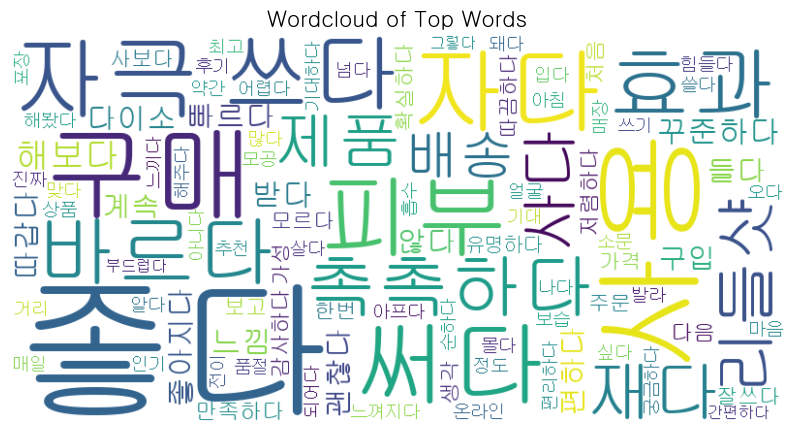

단어 빈도수:
좋다      2979.656007
사용      1583.139654
구매      1175.856000
자다       983.245611
써다       961.330686
           ...     
돼다       114.223369
궁금하다     112.384730
부드럽다     111.399025
그렇다      109.407348
간편하다     109.365322
Length: 100, dtype: float64
분석 완료! 결과는 'word_frequencies.csv' 파일로 저장되었습니다.


In [50]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

# 한글 폰트 설정
def set_korean_font():
    font_path = "C:/Windows/Fonts/gulim.ttc"  # 한글 폰트 경로
    font_name = font_manager.FontProperties(fname=font_path).get_name()
    rc('font', family=font_name)

set_korean_font()

# 데이터 로드
file_path = 'preprocessed_review_data.csv'
data = pd.read_csv(file_path)

# 토큰화된 열 확인
tokens_column = 'Tokens'

# 토큰 리스트를 문자열로 변환 (TF-IDF와 WordCloud는 문자열 입력을 요구함)
data['Tokens_Text'] = data[tokens_column].apply(lambda x: ' '.join(eval(x)) if isinstance(x, str) else '')

# Wordcloud 및 단어 빈도수 계산 함수
def generate_wordcloud_and_frequency(data, tokens_column, n_words=100):
    # TF-IDF 계산
    vectorizer = TfidfVectorizer(max_features=1000)
    tfidf_matrix = vectorizer.fit_transform(data[tokens_column].dropna())
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

    # 단어별 빈도수 계산
    word_frequencies = tfidf_df.sum(axis=0).sort_values(ascending=False)
    top_frequencies = word_frequencies.head(n_words)

    # Wordcloud 생성
    wordcloud = WordCloud(font_path="C:/Windows/Fonts/gulim.ttc",  # 한글 폰트 경로
                           width=800, height=400, background_color='white', colormap='viridis').generate_from_frequencies(top_frequencies)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Wordcloud of Top Words', fontsize=16)
    plt.show()

    return top_frequencies

# 실행
print("Wordcloud 및 단어 빈도수 생성 중...")
word_frequencies = generate_wordcloud_and_frequency(data, 'Tokens_Text')

# 단어 빈도수 결과 출력
print("단어 빈도수:")
print(word_frequencies)

# 결과를 CSV로 저장
word_frequencies.to_csv('word_frequencies.csv', index=True, encoding='utf-8-sig')
print("분석 완료! 결과는 'word_frequencies.csv' 파일로 저장되었습니다.")


Wordcloud 및 단어 빈도수 생성 중...


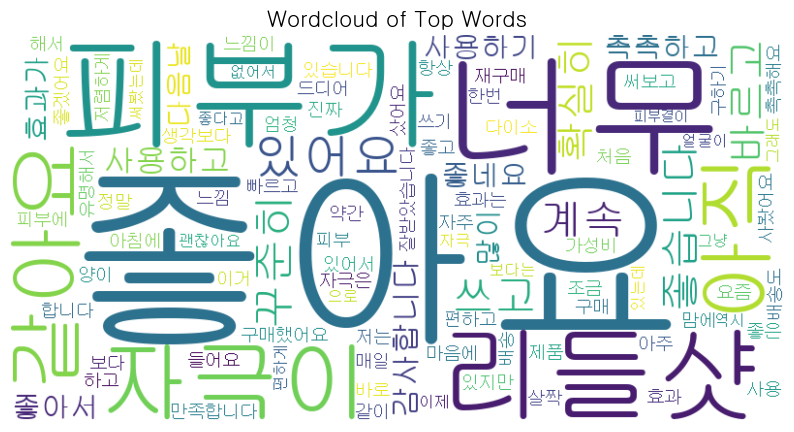

단어 빈도수:
좋아요     1668.515202
너무       621.317879
피부가      508.821520
리들샷      477.620418
자극이      472.034615
           ...     
이제        96.553339
역시        96.136770
있는데       95.755476
편하게       95.465869
피부결이      94.998022
Length: 100, dtype: float64
분석 완료! 결과는 'word_frequencies.csv' 파일로 저장되었습니다.


In [47]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

# 한글 폰트 설정
def set_korean_font():
    font_path = "C:/Windows/Fonts/gulim.ttc"  # 한글 폰트 경로
    font_name = font_manager.FontProperties(fname=font_path).get_name()
    rc('font', family=font_name)

set_korean_font()

# 데이터 로드
file_path = 'preprocessed_review_data.csv'
data = pd.read_csv(file_path)

# 텍스트 열 확인
review_column = 'Review Text'

# Wordcloud 및 단어 빈도수 계산 함수
def generate_wordcloud_and_frequency(data, review_column, n_words=100):
    # TF-IDF 계산
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(data[review_column].dropna())
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

    # 단어별 빈도수 계산
    word_frequencies = tfidf_df.sum(axis=0).sort_values(ascending=False)
    top_frequencies = word_frequencies.head(n_words)

    # Wordcloud 생성
    wordcloud = WordCloud(font_path="C:/Windows/Fonts/gulim.ttc",  # 한글 폰트 경로
                           width=800, height=400, background_color='white', colormap='viridis').generate_from_frequencies(top_frequencies)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Wordcloud of Top Words', fontsize=16)
    plt.show()

    return top_frequencies

# 실행
print("Wordcloud 및 단어 빈도수 생성 중...")
word_frequencies = generate_wordcloud_and_frequency(data, review_column)

# 단어 빈도수 결과 출력
print("단어 빈도수:")
print(word_frequencies)

# 결과를 CSV로 저장
word_frequencies.to_csv('word_frequencies.csv', index=True, encoding='utf-8-sig')
print("분석 완료! 결과는 'word_frequencies.csv' 파일로 저장되었습니다.")
